# Notebook to plot results from a `tdinf` run

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np 
import scipy.linalg as sl

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_palette('colorblind')

from tdinf import group_postprocess, utils, run_sampler, waveform_h5s

### Load in result

Results from `tdinf` runs can easily be loaded in using the `group_postprocess` module:

In [2]:
# Load in the result
result = group_postprocess.load_run_settings_from_directory('output')

The result object has helpful keys:
- `dir` tells you the directory where the output lives, relative to this notebook
- `runs` has `args`, `kwargs` and the `likelihood_manager` for the run corresponding to each cutoff time (including `full`)
- `dfs` has `pandas` `DataFrame`s containing the posterior samples for the run for each cutoff time

In [3]:
# Extract the likelihood_manager for easy use
lm = result['runs']['full']['likelihood_manager']

The different runs are labeled as follows: 
- full data: `full`
- pre cutoff: `pre_XX`
- post cutoff: `post_XX`
This can be seen by printing out the keys to `result['dfs']`:

In [4]:
result['dfs'].keys()

dict_keys(['pre_-0.05', 'pre_0.05', 'full', 'post_0.0', 'post_0.05', 'pre_0.0', 'post_-0.05'])

### Plot posterior distributions for the full run and pre/post cutoff times

Let's plot posterior distributions for each of the 15 binary black hole parameters:

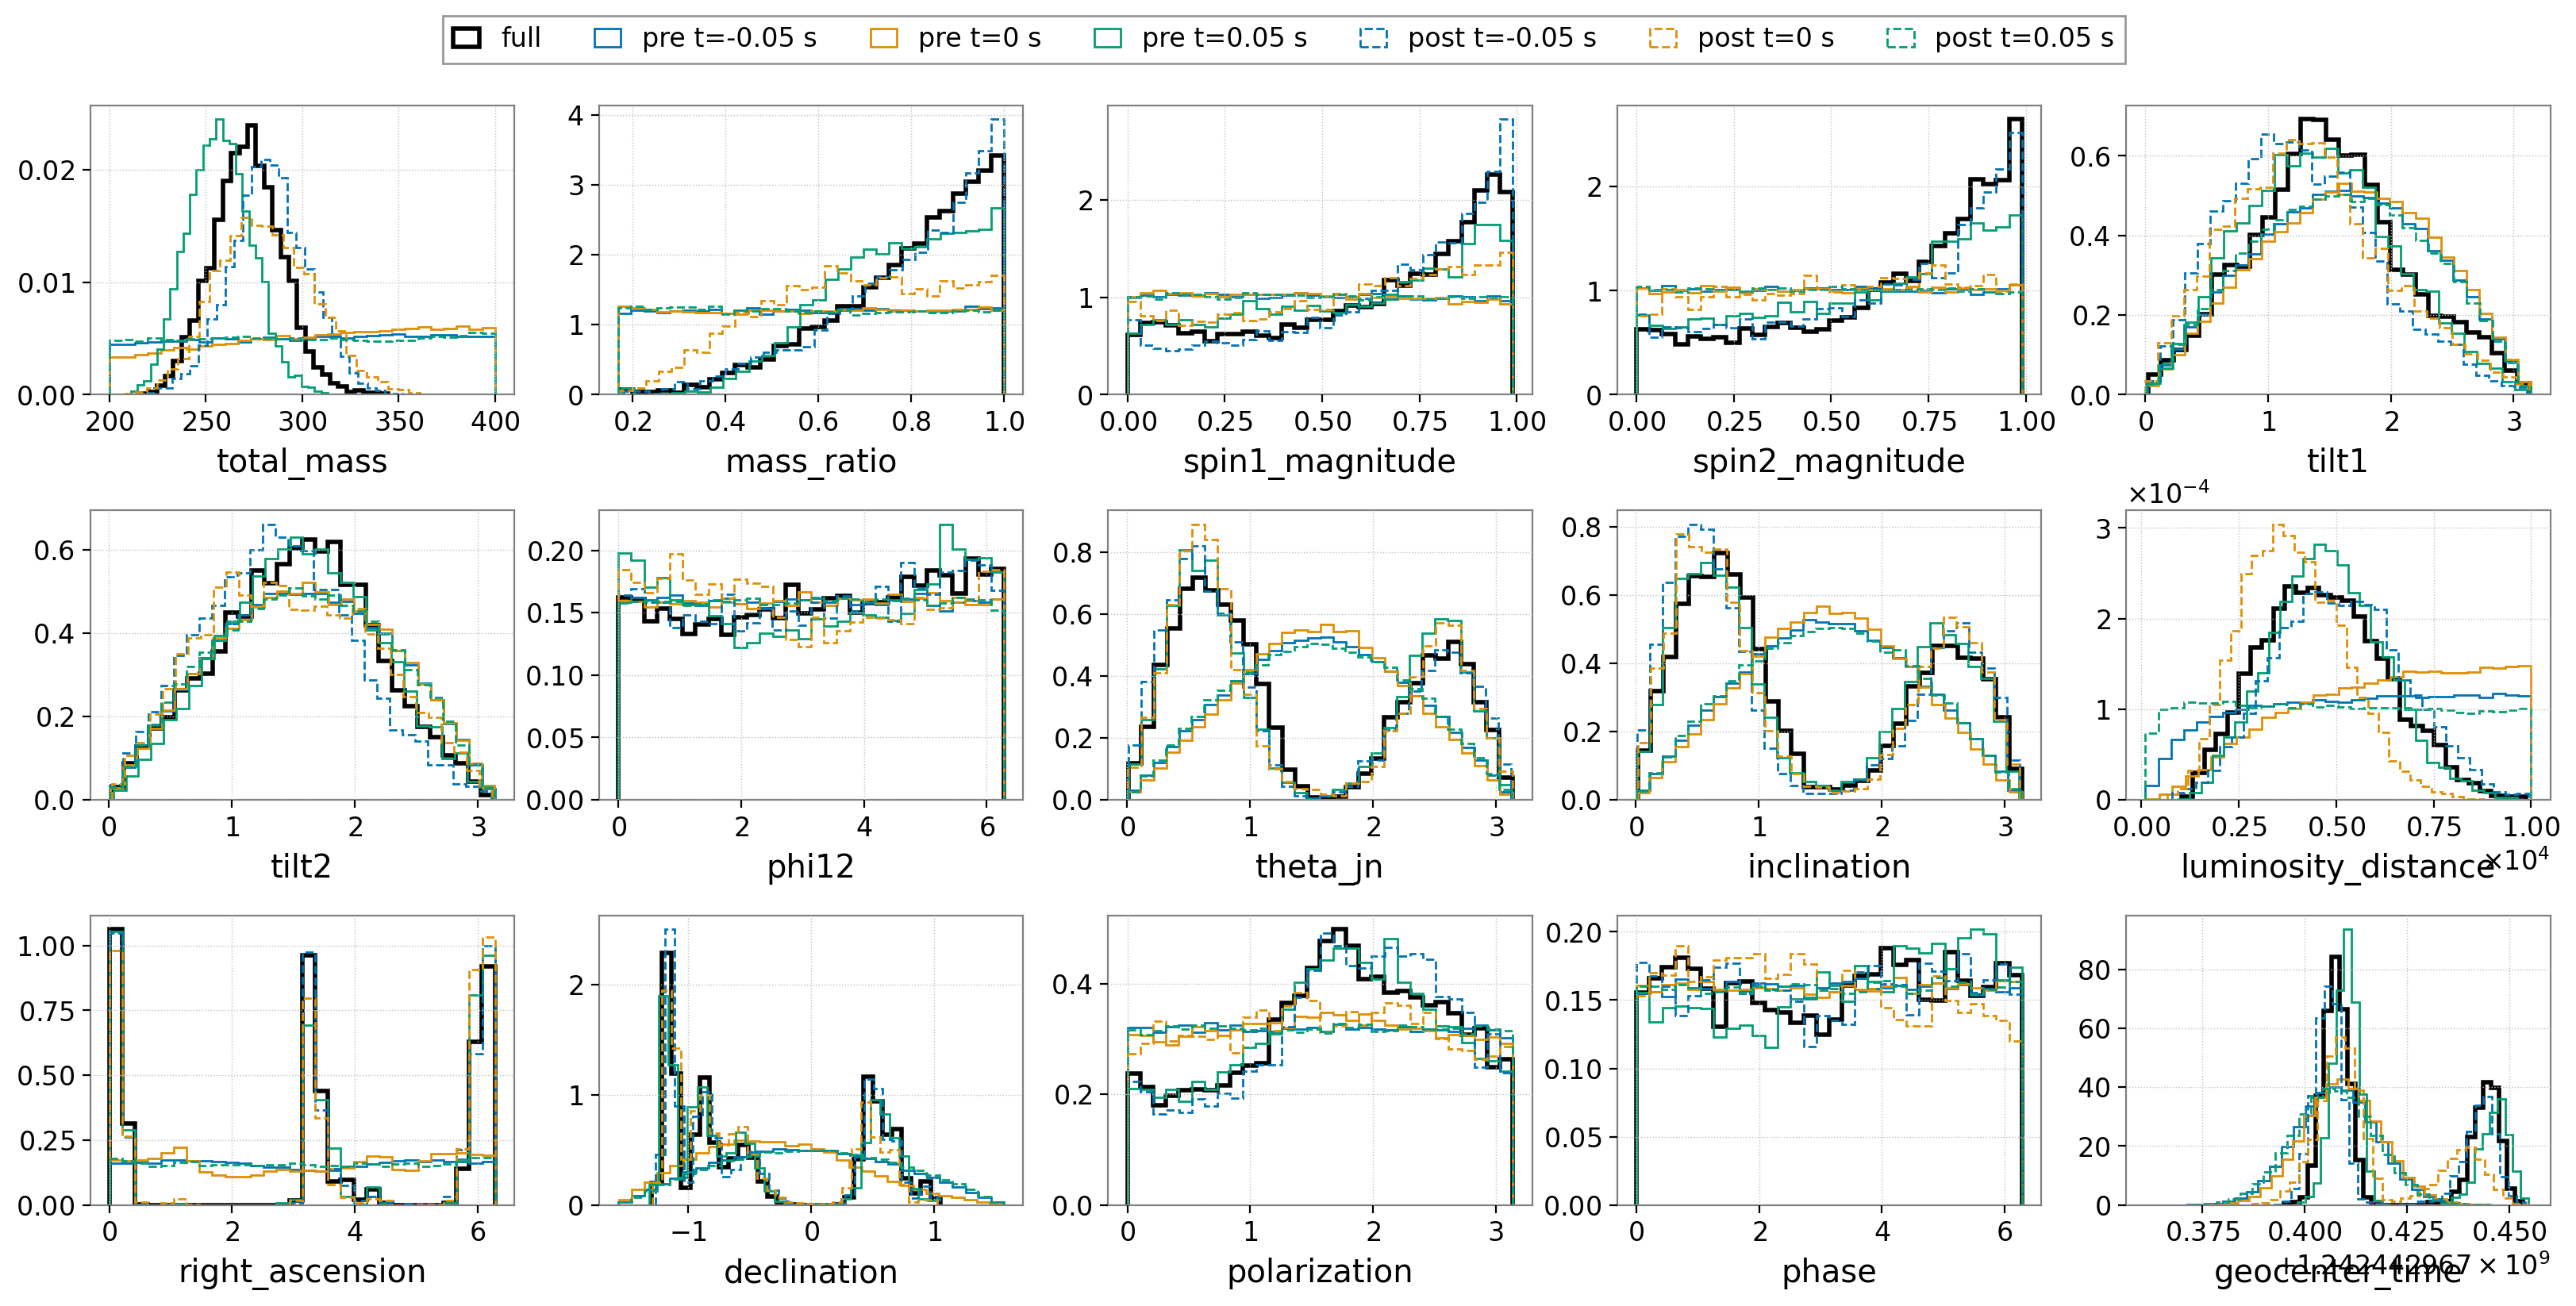

In [5]:
params_to_plot = ['total_mass', 'mass_ratio', 'spin1_magnitude', 'spin2_magnitude',
           'tilt1', 'tilt2', 'phi12', 'theta_jn', 'inclination','luminosity_distance',  
                  'right_ascension', 'declination', 'polarization', 'phase', 'geocenter_time']

fig, axes = plt.subplots(3,5,figsize=(20,9))

for ax, p in zip(axes.flatten(), params_to_plot):
    
    hist_kws = dict(density=True, histtype='step', bins=30) 

    ax.hist(result['dfs']['full'][p], **hist_kws, lw=2, color='k', label='full')

    ax.hist(result['dfs']['pre_-0.05'][p], **hist_kws, label='pre t=-0.05 s', color='C0')
    ax.hist(result['dfs']['pre_0.0'][p], **hist_kws, label='pre t=0 s', color='C1')
    ax.hist(result['dfs']['pre_0.05'][p], **hist_kws, label='pre t=0.05 s', color='C2')
    
    ax.hist(result['dfs']['post_-0.05'][p], **hist_kws, label='post t=-0.05 s', color='C0', ls='--')
    ax.hist(result['dfs']['post_0.0'][p], **hist_kws, label='post t=0 s', color='C1', ls='--')
    ax.hist(result['dfs']['post_0.05'][p], **hist_kws, label='post t=0.05 s', color='C2', ls='--')
    
    ax.set_xlabel(p)
    ax.grid(color='silver', ls=':')

axes[0][0].legend(ncols=7, loc='lower left', bbox_to_anchor=(0.8,1.1))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

From these we are see at what cutoff times information about various parameters is gained or lost. For example, we constrain but slightly under-estimate the total mass for the `pre_0.05` run, while we over-estimate it for `post_-0.05` and `post_0.0`. For other cutoffs, we return the prior, meaning there is not information about total mass looking at, e.g., just the `post_0.05` data.

### Plot strain and waveform reconstructions

For easy visualization, let's generate the whitened strain. We can easily whiten data using the `utils` module. 

In [6]:
# Get whitened strain 
data_dict_wh =  utils.whitenData_dict_TD(lm.data_dict, lm)

Next, load in the waveform reconstructions for these runs with the `waveform_h5s` module, and again whiten them.

In [7]:
# Load waveform reconstructions from the full run
wfs_full = waveform_h5s.load_waveform_h5py(f'output/waveforms/full_waveforms.h5')

# Load waveform reconstructions post t=0 only
wfs_rd = waveform_h5s.load_waveform_h5py(f'output/waveforms/post_0.0_waveforms.h5')

In [8]:
# Whiten waveform reconstructions
L_dict= {} # first, make a Cholesky decomposition of the Toeplitz matrix from the ACF for quick whitening
for ifo in lm.ifos:
    C = sl.toeplitz(lm.rho_dict[ifo])
    L_dict[ifo] = sl.cholesky(C,lower=True)
    
wfs_full_whitened = utils.whiten_wfs_TD(wfs_full['samples'], L_dict)
wfs_rd_whitened = utils.whiten_wfs_TD(wfs_rd['samples'], L_dict)

100%|██████████| 1000/1000 [00:04<00:00, 203.93it/s]


To plot our reconstructions as a function of time from merger, we also need the delay times for each detector. These can be generated using the `likelihood_manager` and the reference time and sky position for our run.

In [9]:
# Get detector delay times 
dt_dict = lm.waveform_manager.antenna_and_time_manager.compute_time_delay_dict(
    result['runs']['full']['kwargs']['right_ascension'], 
    result['runs']['full']['kwargs']['declination'], 
    lm.reference_time, 
    lm.ifos
)

Plot full reconstructions:

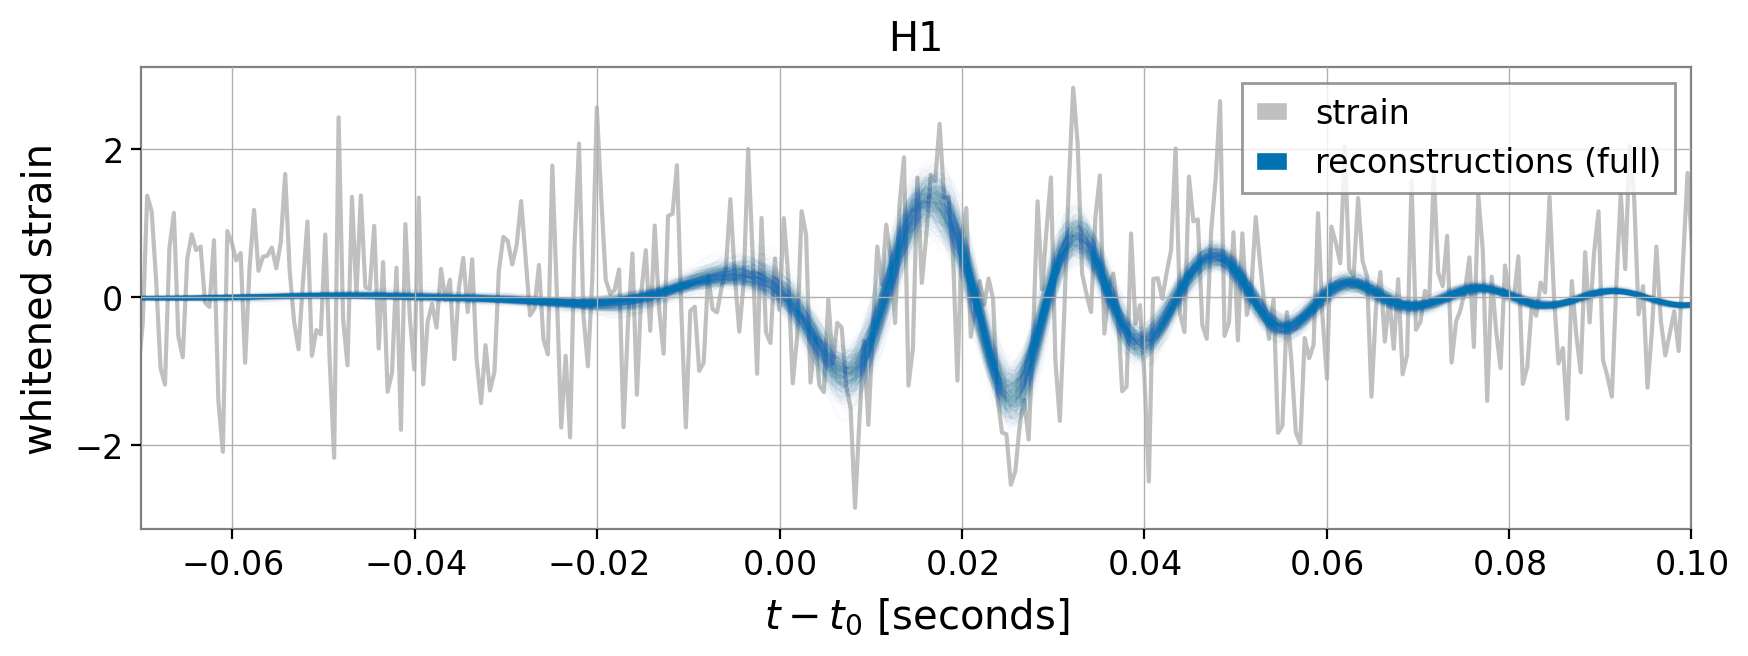

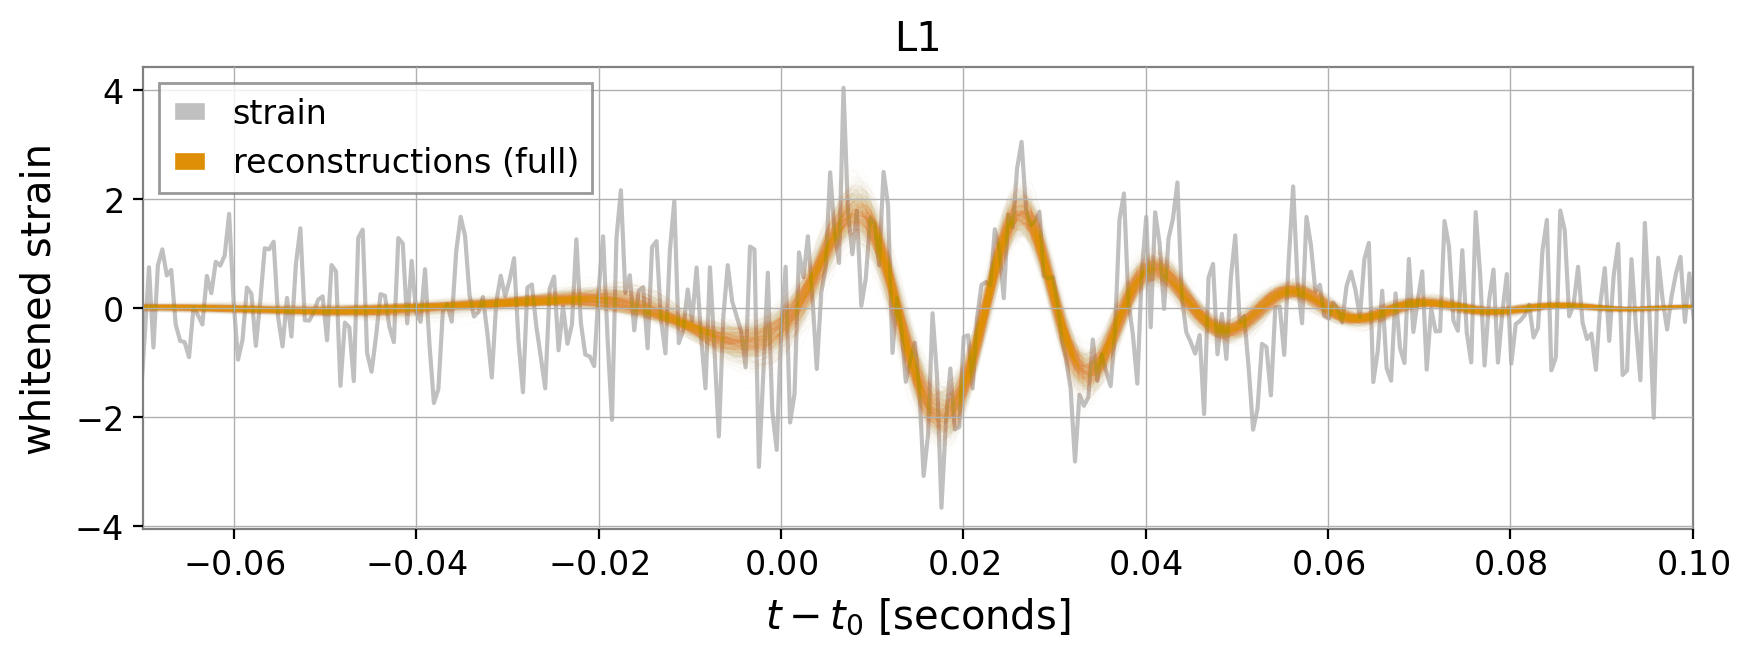

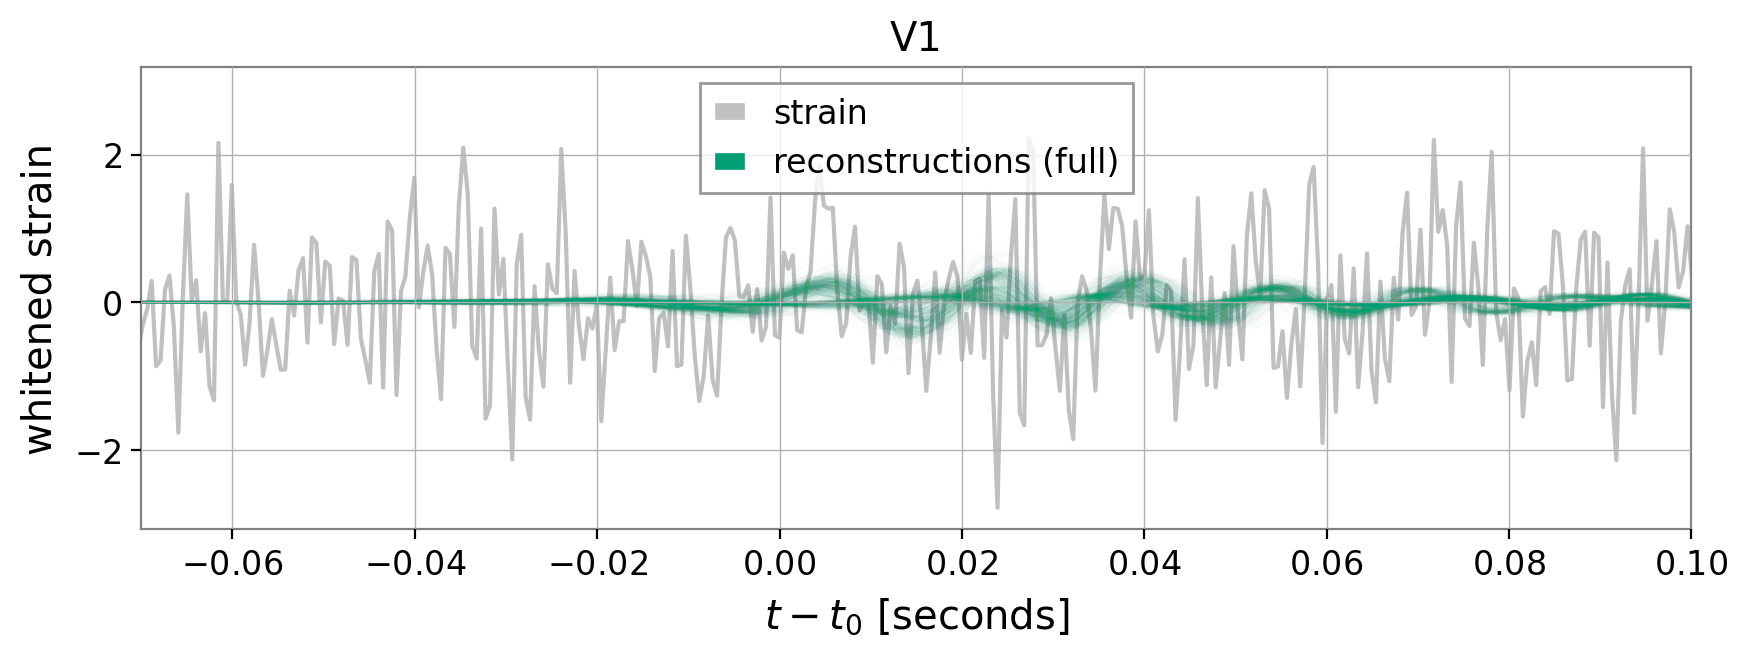

In [10]:
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))

    time_from_merger = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]
    
    plt.plot(time_from_merger, data_dict_wh[ifo], color='silver', zorder=0)
    
    for j in range(len(wfs_full_whitened)):
        plt.plot(time_from_merger, wfs_full_whitened[j][ifo], color=f'C{i}', lw=0.5, alpha=0.01, zorder=2)

    plt.title(ifo)
    handles = [Line2D([], [], color='silver', label='strain'), Line2D([], [], color=f'C{i}', label='reconstructions (full)')]
    plt.legend(handles=handles)
    plt.xlim(-0.07, 0.1)
    plt.xlabel('$t-t_0$ [seconds]')
    plt.ylabel('whitened strain')
    plt.show()

Plot ringdown-only reconstructions:

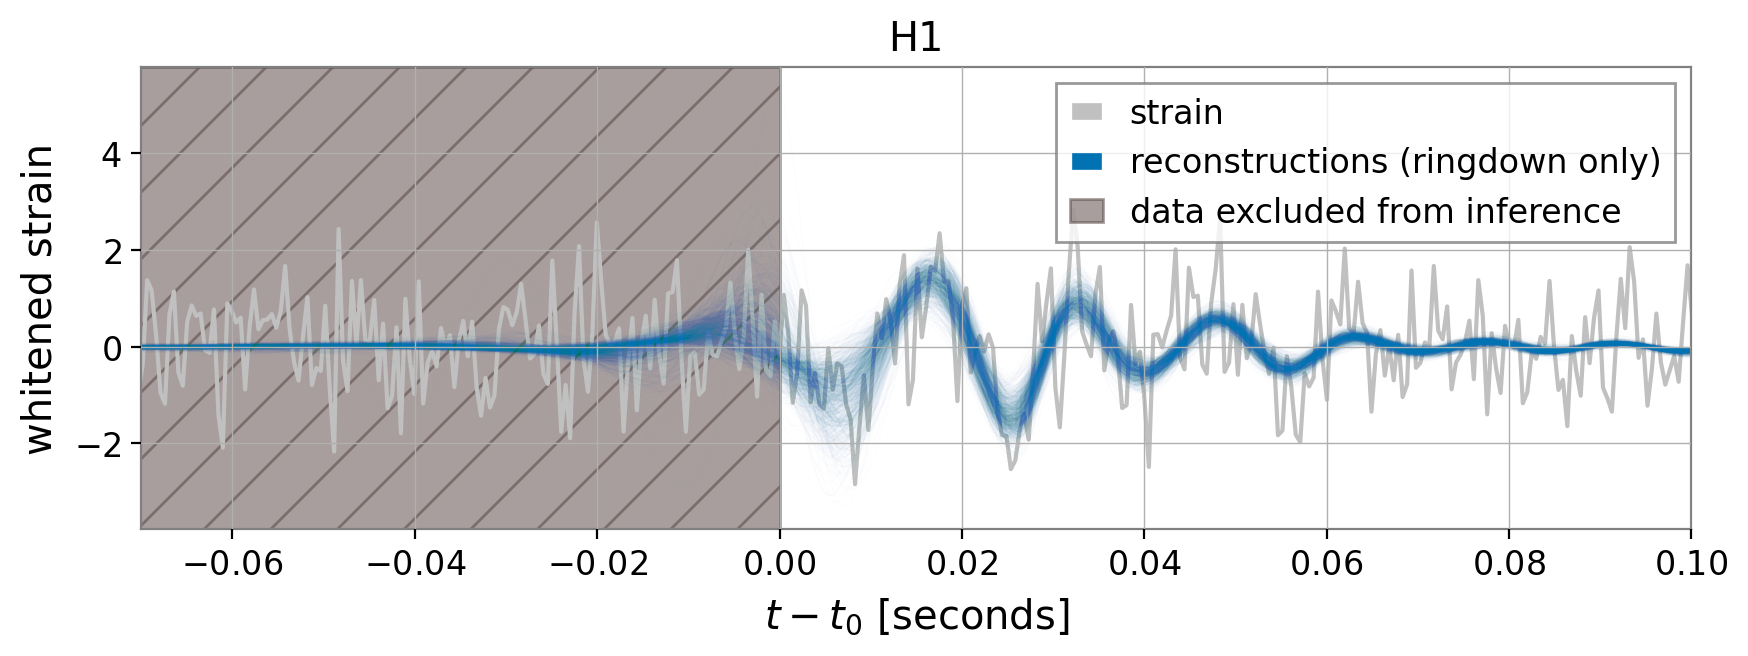

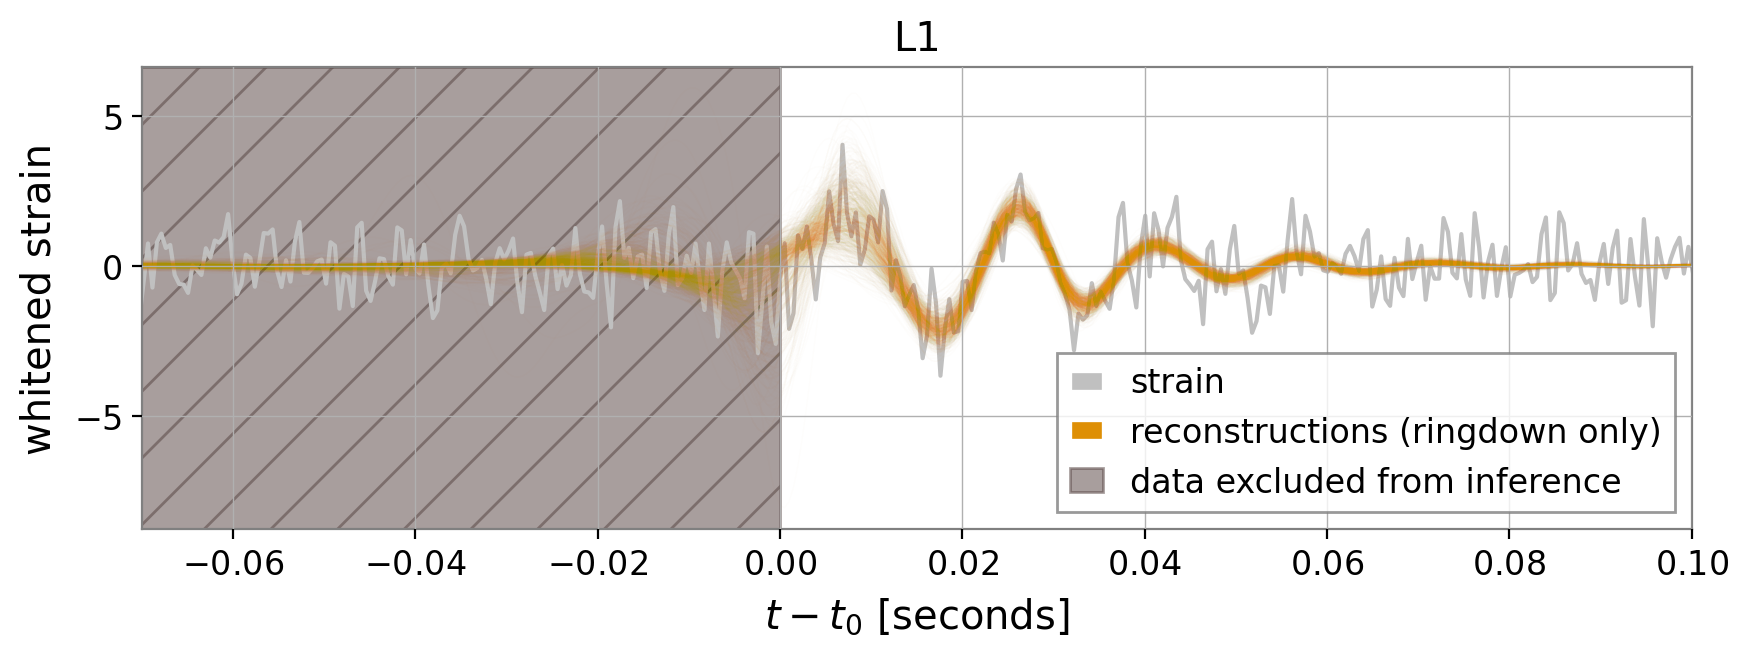

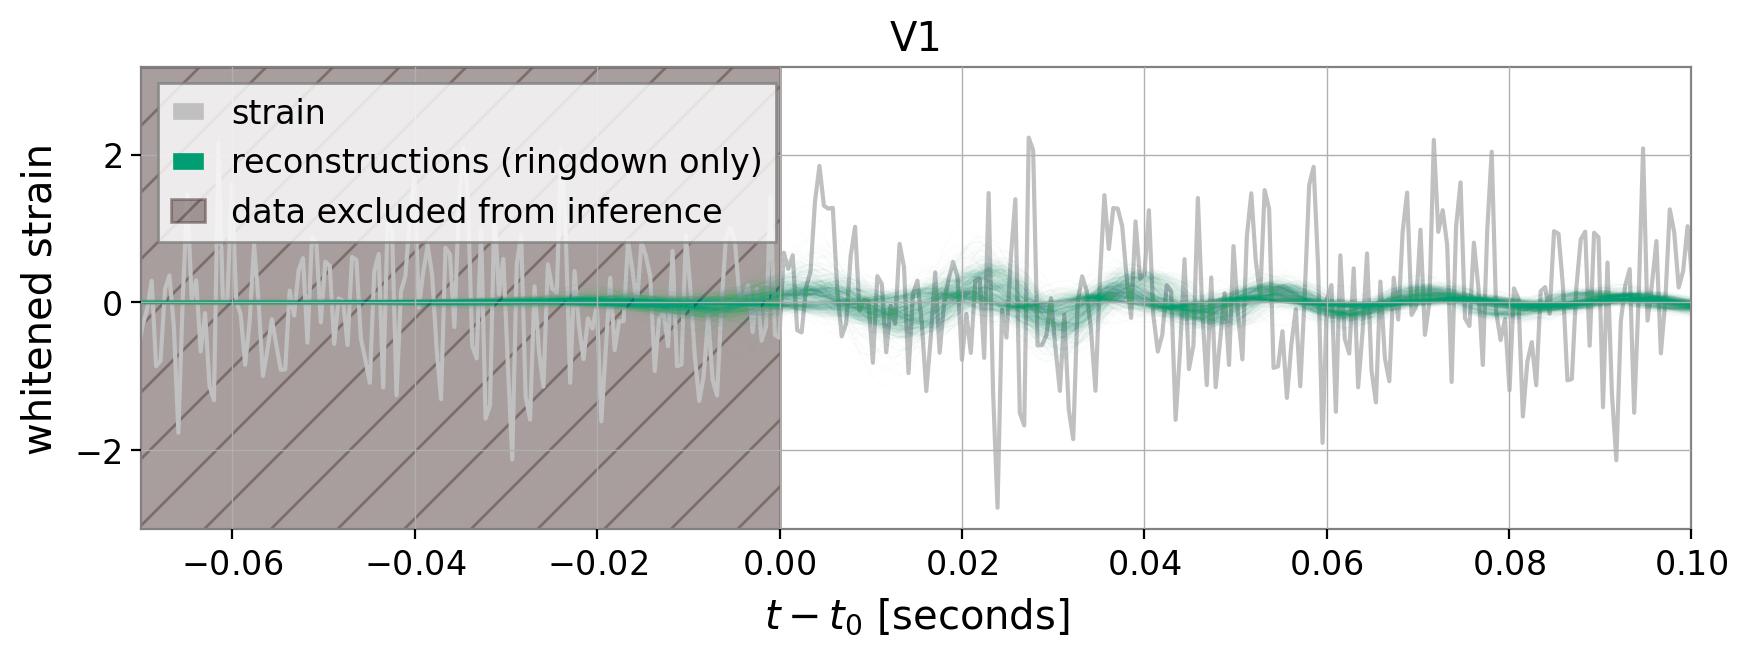

In [11]:
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))

    time_from_merger = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]
    
    plt.plot(time_from_merger, data_dict_wh[ifo], color='silver', zorder=0)
    
    for j in range(len(wfs_rd_whitened)):
        plt.plot(time_from_merger, wfs_rd_whitened[j][ifo], color=f'C{i}', lw=0.5, alpha=0.01, zorder=2)

    plt.title(ifo)
    plt.xlim(-0.07, 0.1)
    plt.xlabel('$t-t_0$ [seconds]')
    plt.ylabel('whitened strain')
    h = plt.axvspan(-0.5, 0, alpha=0.5, color='#523f3d', zorder=-1, hatch='/', label='data excluded from inference')
    handles = [Line2D([], [], color='silver', label='strain'), Line2D([], [], color=f'C{i}', label='reconstructions (ringdown only)'), h]
    plt.legend(handles=handles)
    plt.show()

Compare the two, using the 90% credible intervals on the reconstructed strain:

In [12]:
# Apply function to the full and ringdown-only whitened reconstructions
wh_wf_full_CI = waveform_h5s.get_waveform_CI(wfs_full_whitened,lm)
wh_wf_rd_CI = waveform_h5s.get_waveform_CI(wfs_rd_whitened,lm)

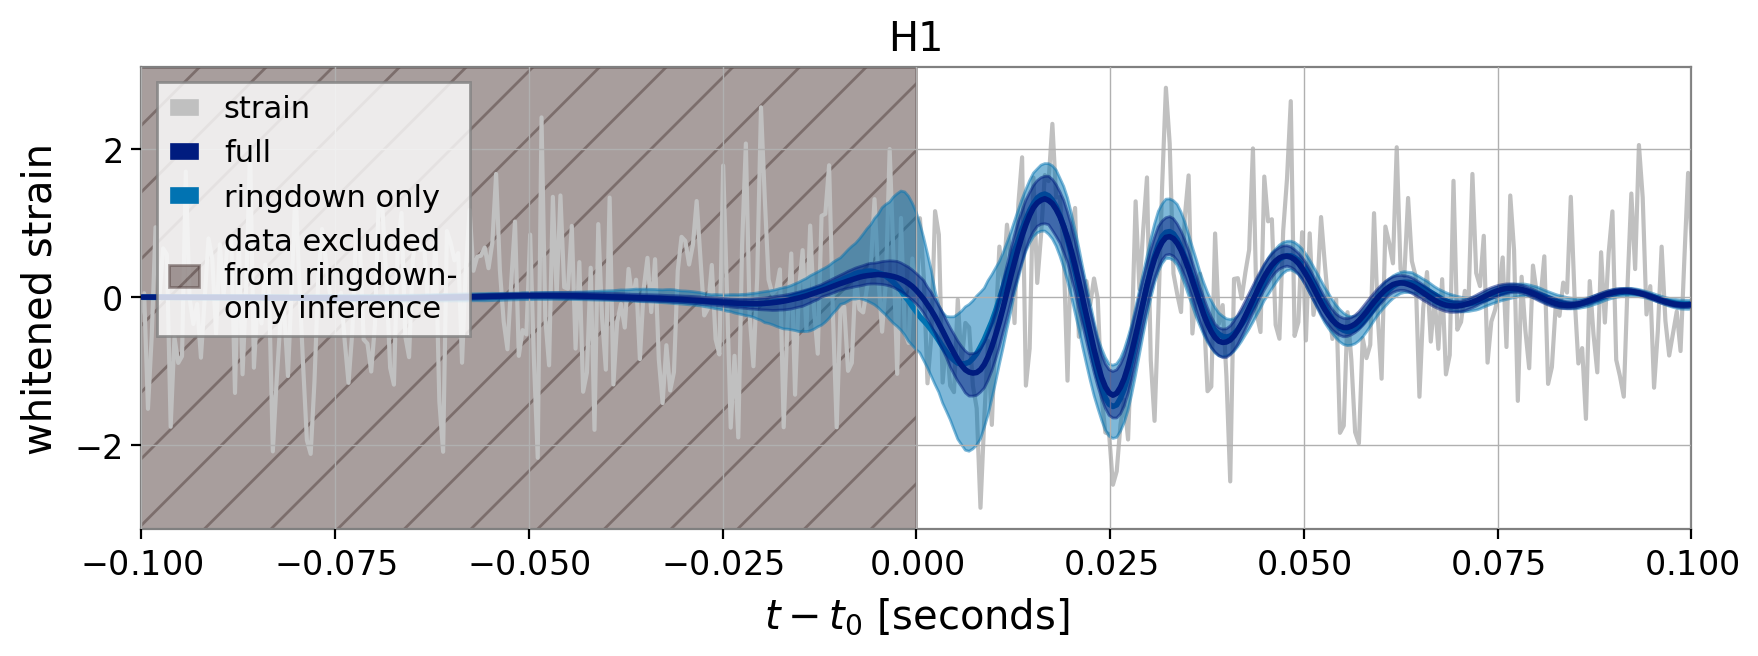

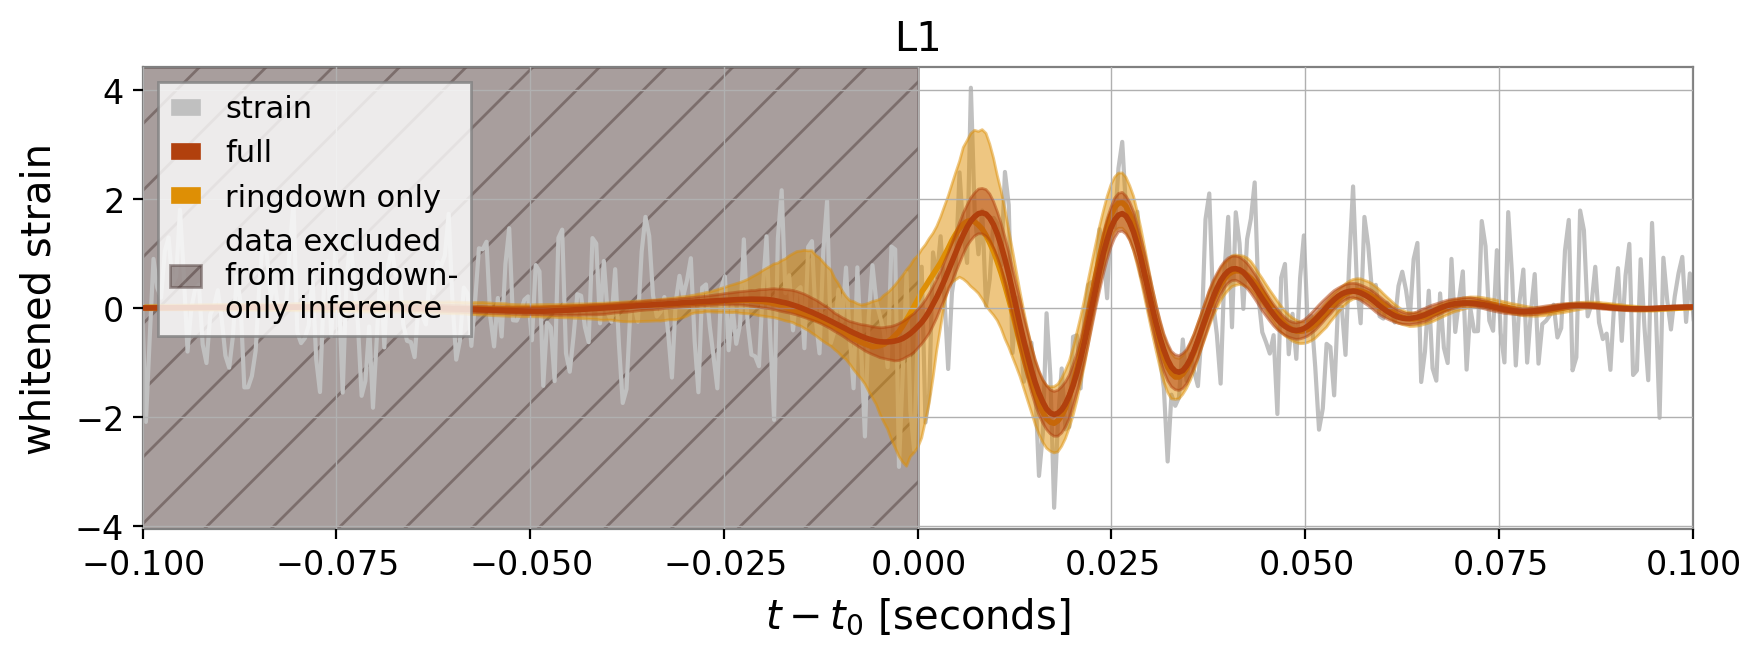

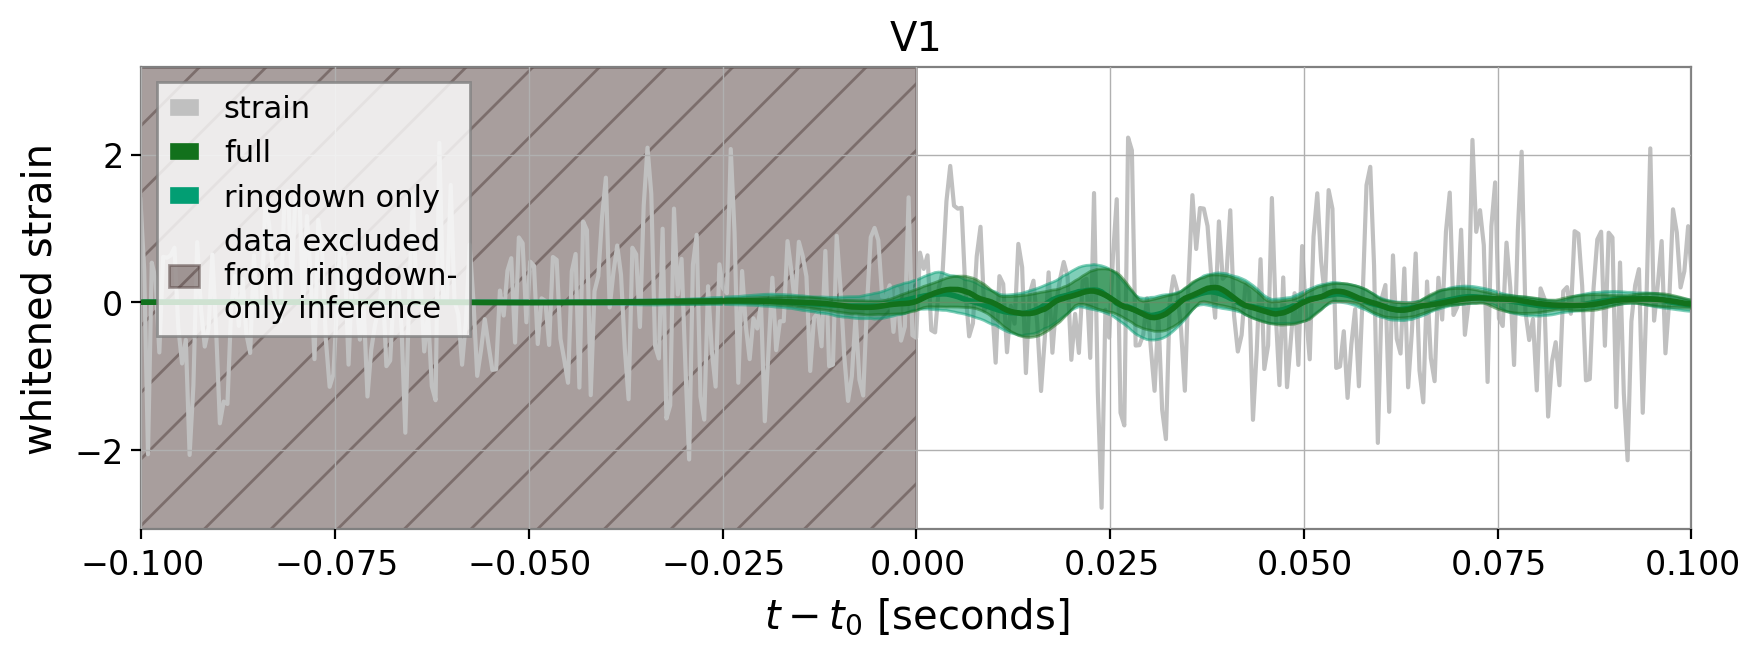

In [13]:
# Plot
cp2 = sns.color_palette("dark")

for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))

    time_from_merger = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    # plot data
    plt.plot(time_from_merger, data_dict_wh[ifo], color='silver', zorder=0, label='strain')

    # plot reconstructions from full 
    plt.plot(time_from_merger, wh_wf_full_CI[ifo]['median'], color=cp2[i], lw=2, label='full', zorder =3)
    plt.fill_between(time_from_merger, wh_wf_full_CI[ifo]['5th'], wh_wf_full_CI[ifo]['95th'], color=cp2[i], alpha=0.5, zorder=3)

    # plot reconstructions from ringdown only 
    plt.plot(time_from_merger, wh_wf_rd_CI[ifo]['median'], color=f'C{i}', lw=2, label='ringdown only',zorder =2)
    plt.fill_between(time_from_merger, wh_wf_rd_CI[ifo]['5th'], wh_wf_rd_CI[ifo]['95th'],  color=f'C{i}', alpha=0.5, zorder=2)
    
    plt.title(ifo)
    plt.xlim(-0.1, 0.1)
    plt.xlabel('$t-t_0$ [seconds]')
    plt.ylabel('whitened strain')
    plt.axvspan(-0.5, 0, alpha=0.5, color='#523f3d', zorder=-1, hatch='/', label='data excluded \nfrom ringdown-\nonly inference')
    plt.legend(loc='upper left', fontsize=11)
    plt.show()

When we exclude the data before t=0, we get wider constrains on the waveform strain during the merger phase of coalescence.  

### SNR

First, we can plot the total SNR of the analyzed signal. Let's compare the full run and the ringdown only run, looking at both the optimal SNR and matched-filter SNR. These are automatically calculated in post-processing of a `tdinf` run:

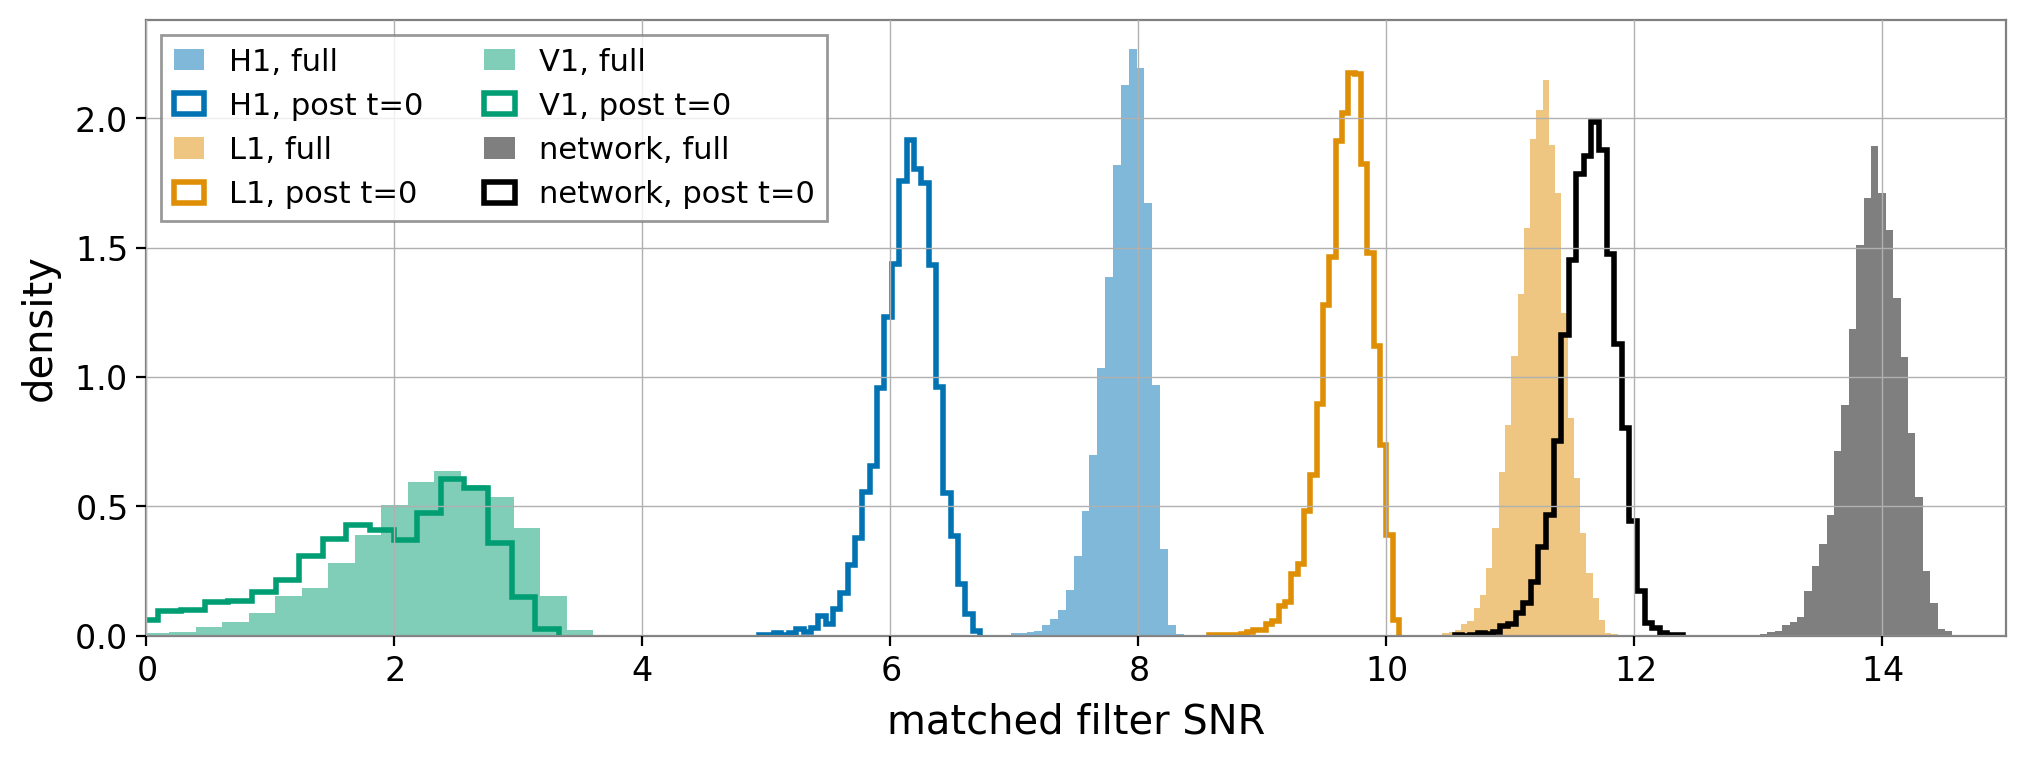

In [18]:
plt.figure(figsize=(12,4))

for i, k in enumerate([*lm.ifos, 'network']): 
    
    p = f'{k}_matched_filter_SNR'

    color = 'k' if k=='network' else f'C{i}'
    hist_kws = dict(density=True, bins=30, color=color)
    
    plt.hist(result['dfs']['full'][p], **hist_kws, alpha=0.5, label=f'{k}, full')
    plt.hist(result['dfs']['post_0.0'][p], **hist_kws, histtype='step', lw=2, label=f'{k}, post t=0')

plt.legend(ncols=2, fontsize=11)
plt.xlabel('matched filter SNR')
plt.ylabel('density')
plt.xlim(0,15)
plt.show()

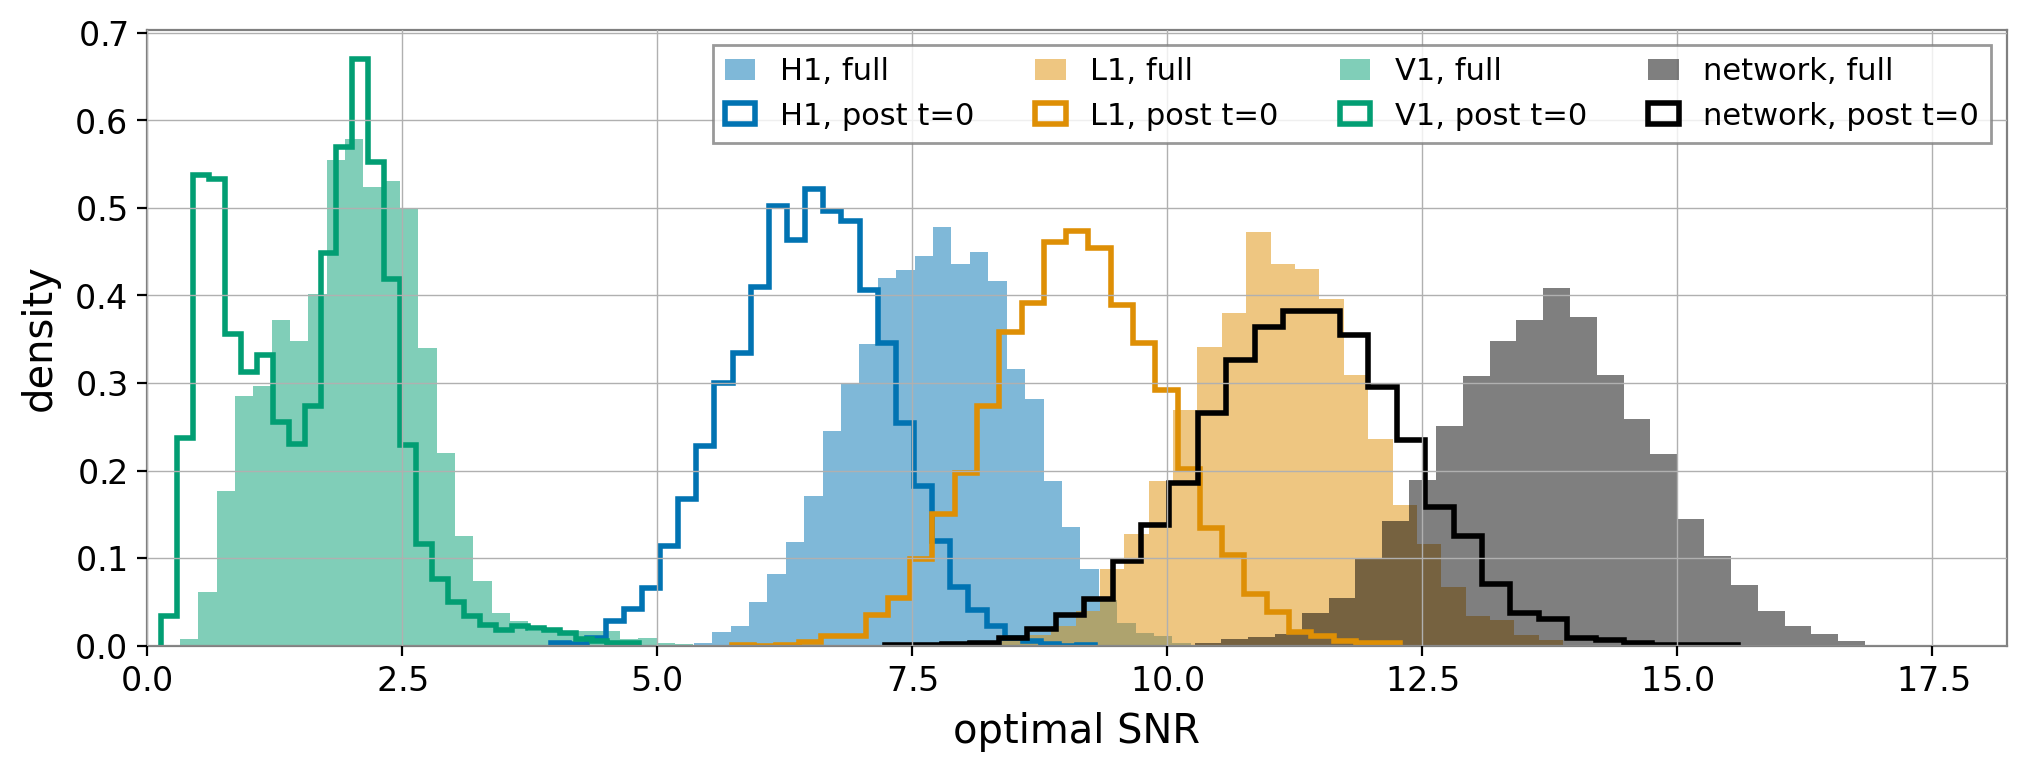

In [19]:
plt.figure(figsize=(12,4))

for i, k in enumerate([*lm.ifos, 'network']): 
    
    p = f'{k}_optimal_SNR'

    color = 'k' if k=='network' else f'C{i}'
    hist_kws = dict(density=True, bins=30, color=color)
    
    plt.hist(result['dfs']['full'][p], **hist_kws, alpha=0.5, label=f'{k}, full')
    plt.hist(result['dfs']['post_0.0'][p], **hist_kws, histtype='step', lw=2, label=f'{k}, post t=0')

plt.legend(ncols=4, fontsize=11)
plt.xlabel('optimal SNR')
plt.ylabel('density')
plt.xlim(0,)
plt.show()

We can also look at the *cumulative* SNR over time. This is done in the time-domain by taking the square root of the cumulative sum of the whitened waveform squared. As an example, we plot the cumulative optimal SNR vs. time for the full run. 

In [20]:
cumuative_snr_dict = {}

for ifo in lm.ifos: 
    snr_ifo = []
    for wf in wfs_full_whitened:
        snr_ifo.append( np.sqrt(np.cumsum(wf[ifo]**2)) )
        
    cumuative_snr_dict[ifo] = np.transpose(snr_ifo)

cumuative_snr_dict['network'] = np.sqrt(np.sum([cumuative_snr_dict[ifo]**2 for ifo in lm.ifos], axis=0))

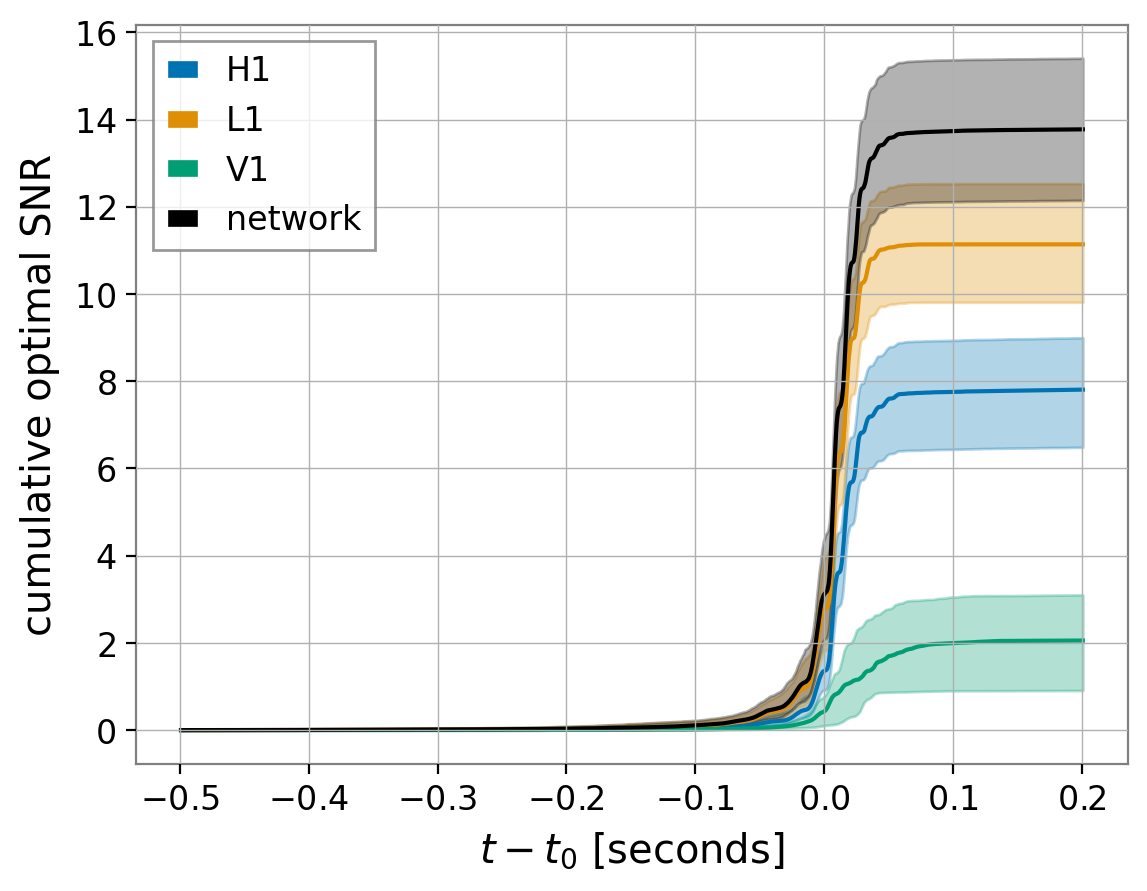

In [21]:
# Plot
plt.figure()
for i, ifo in enumerate([*lm.ifos, 'network']):   
    
    q = np.quantile(cumuative_snr_dict[ifo], (0.05, 0.5, 0.95), axis=1)

    time_from_merger = lm.time_dict['L1'] - lm.reference_time - dt_dict['L1']

    color = 'k' if ifo=='network' else f'C{i}'
    plt.plot(time_from_merger, q[1], color=color, label=ifo)
    plt.fill_between(time_from_merger, q[0], q[2], color=color,alpha=0.3)
    
plt.legend()
plt.xlabel('$t-t_0$ [seconds]')
plt.ylabel('cumulative optimal SNR')
plt.show()

### If you have any further questions about running `tdinf` or plotting/interpreting results, reach out to `simona.miller@ligo.org`.